<table style="width: 100%;"> <tr> <td style="width: 20%; vertical-align: top;"> <img src="https://upload.wikimedia.org/wikipedia/commons/archive/f/fb/20161010213812%21Escudo-UdeA.svg" alt="UdeA" height="150px"> </td> <td style="width: 80%; padding-left: 20px;"> <strong style="font-size: 30px;">EXPLORACIÓN DEL CONJUNTO DE DATOS PARA EL DESARROLLO DE UN SISTEMA DE RECOMENDACIÓN DE PELÍCULAS - PROYECTO MARKETING</strong><br><br> <span style="font-size: 30px;"> Luisa Fernanda Alzate Cuartas <br> Juan Camilo Henao Caro<br>Isabella Mendez Hoyos<br> Fernando Antonio Piñeres Ramos </span> </td> </tr> </table>

#### LIBRERÍAS REQUERIDAS

In [1]:
#Conexión de Google Colab con Drive.
from google.colab import drive
drive.mount('/content/drive')

#Acceder a los archivos de la carpeta marketing para el uso de funciones.
import sys
sys.path.append('/content/drive/MyDrive/marketing/Marketing')

Mounted at /content/drive


In [2]:
import pandas as pd # Manipulación y el analísis de datos.
import sqlite3 as sql # Interactuar con base de datos SQL usando Python.

import matplotlib.pyplot as plt
import seaborn as sns

#### CONEXIÓN CON LA BASE DE DATOS

In [3]:
#Establece una conexión a la base de datos SQLite ubicada en "content/db_movies"
conexion = sql.connect('/content/drive/MyDrive/marketing/Marketing/data/db_movies_copy.db')

# Crear un cursor a partir de la conexión, que permita ejecutar comando SQL sobre la base de datos.
cur = conexion.cursor()

In [4]:
# Ejecuta una consulta SQL que obtiene los nombres de todas las tablas existentes en la base de datos.
cur.execute("SELECT name FROM sqlite_master where type='table' ")

# Recupera todos los resultados de la consulta anterior en forma de lista de tuplas.
cur.fetchall()

[('ratings',), ('movies',)]

#### EXPLORACIÓN DE LAS TABLAS

##### TABLA MOVIES

In [5]:
# Ejecuta la consulta SQL "SELECT * FROM movies" sobre la base de datos y carga los resultados en un DataFrame de pandas.
table_movies = pd.read_sql_query("SELECT * FROM movies", conexion)
table_movies


,movieId,año,titulo,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,117867,2014,'71,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,97757,2004,'Hellboy': The Seeds of Creation,1,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,26564,1986,'Round Midnight,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,27751,2004,'Salem's Lot,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,779,1997,'Til There Was You,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9698,2600,1999,eXistenZ,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
9699,5507,2002,xXx,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9700,33158,2005,xXx: State of the Union,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9701,2478,1986,¡Three Amigos!,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [6]:
duplicados_titulo_anio = table_movies[table_movies.duplicated(subset=['titulo', 'año'], keep=False)]
display(duplicados_titulo_anio.sort_values(['titulo', 'año']))

,movieId,año,titulo,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western


In [ ]:

table_movies = table_movies.sort_values(by=['titulo', 'año'])
table_movies.drop_duplicates(subset=['titulo', 'año'], keep='first', inplace=True)

# Guardar la tabla modificada en la base de datos
table_movies.to_sql('movies', conexion, if_exists='replace', index=False)

9703

In [7]:
table_ratings = pd.read_sql_query("SELECT * FROM ratings", conexion)
table_ratings.head()

,userId,movieId,rating,day,month,hour,year
0,1,1,4.0,30,7,18,2000
1,1,3,4.0,30,7,18,2000
2,1,6,4.0,30,7,18,2000
3,1,47,5.0,30,7,19,2000
4,1,50,5.0,30,7,18,2000


In [8]:
# Realizar el INNER JOIN entre ratings y movies
query = """
SELECT r.userId,r.rating,r.day,r.month,r.hour,r.year, m.*
FROM ratings r
INNER JOIN movies m ON r.movieId = m.movieId
"""
df = pd.read_sql_query(query, conexion)

# Mostrar las primeras filas del DataFrame
df.head()


,userId,rating,day,month,hour,year,movieId,año,titulo,Action,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,4.0,30,7,18,2000,1,1995,Toy Story,0,...,0,0,0,0,0,0,0,0,0,0
1,1,4.0,30,7,18,2000,3,1995,Grumpier Old Men,0,...,0,0,0,0,0,1,0,0,0,0
2,1,4.0,30,7,18,2000,6,1995,Heat,1,...,0,0,0,0,0,0,0,1,0,0
3,1,5.0,30,7,19,2000,47,1995,Seven (a.k.a. Se7en),0,...,0,0,0,0,1,0,0,1,0,0
4,1,5.0,30,7,18,2000,50,1995,"Usual Suspects, The",0,...,0,0,0,0,1,0,0,1,0,0


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100783.0,326.127363,182.601809,1.0,177.0,325.0,477.0,610.0
rating,100783.0,3.501573,1.042467,0.5,3.0,3.5,4.0,5.0
day,100783.0,15.853894,8.808146,1.0,8.0,16.0,23.0,31.0
month,100783.0,6.414415,3.400851,1.0,4.0,6.0,9.0,12.0
hour,100783.0,12.608327,7.337617,0.0,6.0,14.0,19.0,23.0
year,100783.0,2007.717958,6.888628,1996.0,2002.0,2007.0,2015.0,2018.0
movieId,100783.0,19368.331415,35413.292156,1.0,1198.5,2990.0,8014.0,193609.0
año,100783.0,1994.441384,14.359614,1902.0,1990.0,1997.0,2003.0,2018.0
Action,100783.0,0.303950,0.459964,0.0,0.0,0.0,1.0,1.0
Adventure,100783.0,0.239733,0.426923,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.describe(include="object").T

,count,unique,top,freq
titulo,100783,9413,Forrest Gump,329


In [ ]:
pd.read_sql_query("""
PRAGMA table_info(movies);
""", conexion)

,cid,name,type,notnull,dflt_value,pk
0,0,movieId,INTEGER,0,None,0
1,1,año,INTEGER,0,None,0
2,2,titulo,TEXT,0,None,0
3,3,Action,INTEGER,0,None,0
4,4,Adventure,INTEGER,0,None,0
5,5,Animation,INTEGER,0,None,0
6,6,Children,INTEGER,0,None,0
7,7,Comedy,INTEGER,0,None,0
8,8,Crime,INTEGER,0,None,0
9,9,Documentary,INTEGER,0,None,0


In [ ]:
display(pd.read_sql_query("SELECT COUNT(*) AS total_movies FROM movies", conexion))
display(pd.read_sql_query("SELECT COUNT(*) AS total_ratings FROM ratings", conexion))


,total_movies
0,9703


,total_ratings
0,100789


In [ ]:
query = """
SELECT rating, COUNT(*) AS total ,  ROUND((COUNT(*) * 100.0 / (SELECT COUNT(*) FROM ratings)),2) AS percentage
FROM ratings
GROUP BY rating
ORDER BY rating DESC
"""
pd.read_sql_query(query, conexion)


,rating,total,percentage
0,5.0,13204,13.10
1,4.5,8543,8.48
2,4.0,26810,26.60
3,3.5,13130,13.03
4,3.0,20041,19.88
5,2.5,5544,5.50
6,2.0,7549,7.49
7,1.5,1791,1.78
8,1.0,2809,2.79
9,0.5,1368,1.36


In [ ]:
query = """
SELECT m.titulo, COUNT(*) AS total_ratings
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY r.movieId
ORDER BY total_ratings DESC
LIMIT 20
"""
pd.read_sql_query(query, conexion)


,titulo,total_ratings
0,Forrest Gump,329
1,"Shawshank Redemption, The",317
2,Pulp Fiction,307
3,"Silence of the Lambs, The",279
4,"Matrix, The",278
5,Star Wars: Episode IV - A New Hope,251
6,Jurassic Park,238
7,Braveheart,237
8,Terminator 2: Judgment Day,224
9,Schindler's List,220


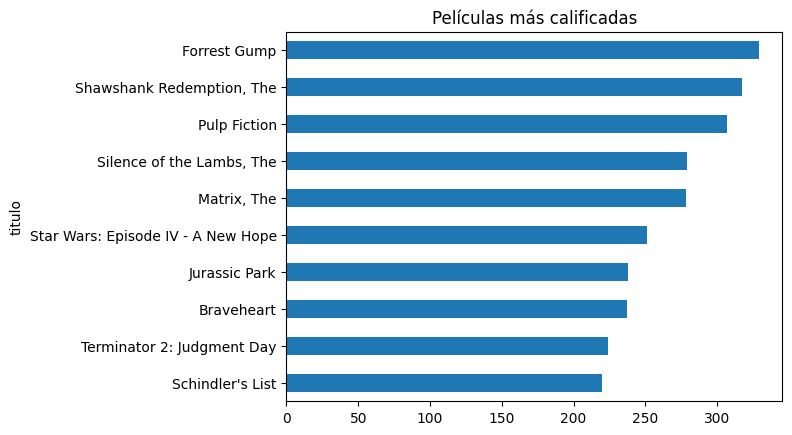

In [ ]:
populares = df.groupby("titulo").size().sort_values(ascending=False).head(10)
populares.plot(kind="barh", title="Películas más calificadas")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
query = """
SELECT userId, COUNT(*) AS total_ratings
FROM ratings
GROUP BY userId
ORDER BY total_ratings DESC
LIMIT 5
"""
pd.read_sql_query(query, conexion)


,userId,total_ratings
0,414,2696
1,599,2474
2,474,2108
3,448,1862
4,274,1346




```
# Ha realizado 2,696 valoraciones de películas.

Suponiendo una actividad constante durante 10 años, eso equivale a:

270 películas por año,

aproximadamente 5 películas por semana.

Este ritmo de visualización y calificación es razonable para un cinéfilo activo o un usuario frecuente en plataformas como IMDb o MovieLens.

Por lo tanto, los datos son coherentes y creíbles dentro del contexto de una base de datos de valoraciones de películas.
```



In [ ]:
query = """
SELECT userId, COUNT(*) AS total_ratings
FROM ratings
GROUP BY userId
ORDER BY total_ratings ASC
LIMIT 10
"""
pd.read_sql_query(query, conexion)

,userId,total_ratings
0,53,20
1,147,20
2,189,20
3,194,20
4,207,20
5,257,20
6,278,20
7,320,20
8,406,20
9,431,20


In [ ]:
query = """
SELECT m.titulo, COUNT(*) AS num_ratings, ROUND(AVG(r.rating), 2) AS avg_rating
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY r.movieId
HAVING COUNT(*) >= 10
ORDER BY avg_rating DESC
LIMIT 10
"""
pd.read_sql_query(query, conexion)


,titulo,num_ratings,avg_rating
0,Secrets & Lies,11,4.59
1,Guess Who's Coming to Dinner,11,4.55
2,Paths of Glory,12,4.54
3,"Streetcar Named Desire, A",20,4.48
4,"Celebration, The (Festen)",12,4.46
5,Ran,15,4.43
6,"Shawshank Redemption, The",317,4.43
7,His Girl Friday,14,4.39
8,All Quiet on the Western Front,10,4.35
9,"Hustler, The",18,4.33


In [ ]:
query = """
SELECT r.year, ROUND(AVG(r.rating), 2) AS avg_rating, COUNT(*) AS total
FROM ratings r
GROUP BY r.year
ORDER BY r.year
"""
pd.read_sql_query(query, conexion)


,year,avg_rating,total
0,1996,3.54,6040
1,1997,3.73,1916
2,1998,3.44,507
3,1999,3.77,2439
4,2000,3.39,10061
5,2001,3.51,3922
6,2002,3.61,3478
7,2003,3.50,4014
8,2004,3.51,3279
9,2005,3.43,5813


In [ ]:

query = """
SELECT año, COUNT(*) AS cantidad_peliculas
FROM movies
GROUP BY año
ORDER BY  cantidad_peliculas DESC
"""


# Ejecutar y mostrar el resultado
df_peliculas_por_anio = pd.read_sql_query(query, conexion)
display(df_peliculas_por_anio)


,año,cantidad_peliculas
0,2002,310
1,2006,295
2,2001,294
3,2007,284
4,2000,283
...,...,...
101,1917,1
102,1915,1
103,1908,1
104,1903,1


In [ ]:
query = """ SELECT hour, COUNT(*) AS cantidad
FROM ratings
GROUP BY hour
ORDER BY cantidad DESC
LIMIT 10
"""
pd.read_sql_query(query, conexion)

,hour,cantidad
0,20,6527
1,17,6341
2,21,6268
3,19,6201
4,18,5724
5,22,5387
6,16,5164
7,2,5134
8,1,4957
9,0,4481


In [ ]:
query = """ SELECT month, COUNT(*) AS cantidad
FROM ratings
GROUP BY month
ORDER BY cantidad DESC
LIMIT 10
"""
pd.read_sql_query(query, conexion)

,month,cantidad
0,5,10873
1,11,9674
2,8,9072
3,3,8876
4,6,8821
5,1,8677
6,9,8504
7,4,7725
8,2,7630
9,10,7147


In [22]:
query ="""SELECT
  (año / 10) * 10 AS decada,
  COUNT(*) AS cantidad
FROM movies
GROUP BY decada
ORDER BY decada DESC
"""
pd.read_sql_query(query, conexion)


,decada,cantidad
0,2010,1918
1,2000,2846
2,1990,2207
3,1980,1175
4,1970,499
5,1960,400
6,1950,278
7,1940,197
8,1930,136
9,1920,37


In [ ]:
query = """SELECT
    SUM(Action) AS Action,
    SUM(Comedy) AS Comedy,
    SUM(Drama) AS Drama,
    SUM(Horror) AS Horror,
    SUM(Romance) AS Romance,
    SUM(Thriller) AS Thriller,
    SUM(Adventure) AS Adventure,
    SUM(Animation) AS Animation,
    SUM(Children) AS Children,
    SUM(Documentary) AS Documentary,
    SUM(Fantasy) AS Fantasy,
    SUM(IMAX) AS IMAX,
    SUM(Musical) AS Musical,
    SUM(Mystery) AS Mystery,
    SUM(War) AS War,
    SUM(Western) AS Western,
    SUM("Film-Noir") AS "Film-Noir",
    SUM("Sci-Fi") AS "Sci-Fi"


FROM movies;
"""
pd.read_sql_query(query, conexion)


,Action,Comedy,Drama,Horror,Romance,Thriller,Adventure,Animation,Children,Documentary,Fantasy,IMAX,Musical,Mystery,War,Western,Film-Noir,Sci-Fi
0,1827,3755,4359,978,1593,1892,1263,611,664,440,779,158,334,573,382,167,87,978


In [ ]:
generos = ["Comedy", "Action", "Romance", "Thriller","Adventure","Animation","Horror","War","Western", "Children", "Documentary", "Thriller","Film-Noir","Fantasy","Mystery","Drama","Sci-Fi","Musical","IMAX"]

for g in generos:
    media = df[df[g] == 1]["rating"].mean()
    print(f"Promedio de rating para {g}: {media:.2f}")


Promedio de rating para Comedy: 3.38
Promedio de rating para Action: 3.45
Promedio de rating para Romance: 3.51
Promedio de rating para Thriller: 3.49
Promedio de rating para Adventure: 3.51
Promedio de rating para Animation: 3.63
Promedio de rating para Horror: 3.26
Promedio de rating para War: 3.81
Promedio de rating para Western: 3.58
Promedio de rating para Children: 3.41
Promedio de rating para Documentary: 3.80
Promedio de rating para Thriller: 3.49
Promedio de rating para Film-Noir: 3.92
Promedio de rating para Fantasy: 3.49
Promedio de rating para Mystery: 3.63
Promedio de rating para Drama: 3.66
Promedio de rating para Sci-Fi: 3.46
Promedio de rating para Musical: 3.56
Promedio de rating para IMAX: 3.62


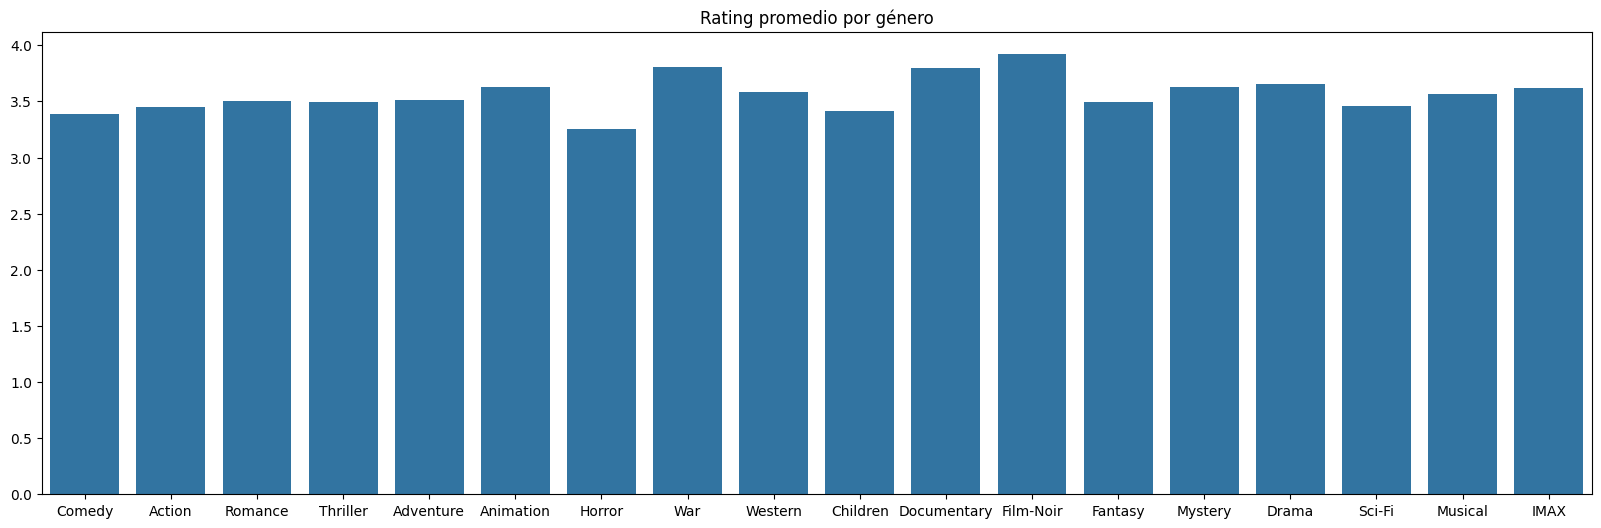

In [ ]:
plt.figure(figsize=(20, 6))
genero_promedios = {g: df[df[g] == 1]["rating"].mean() for g in generos}
sns.barplot(x=list(genero_promedios.keys()), y=list(genero_promedios.values()))
plt.title("Rating promedio por género")
plt.show()


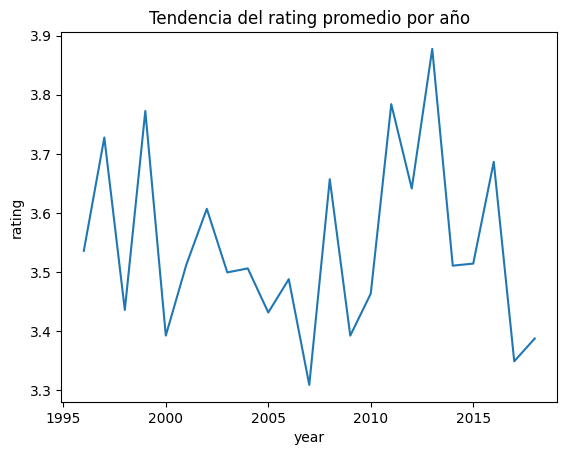

In [ ]:
sns.lineplot(data=df.groupby("year")["rating"].mean().reset_index(), x="year", y="rating")
plt.title("Tendencia del rating promedio por año")
plt.show()


In [ ]:
def graficos_distribucion(df, variables):
    sns.set(style="darkgrid")

    for var in variables:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        fig.suptitle(f'Distribución de la variable: {var}', fontsize=16)

        # Histograma
        sns.histplot(df[var].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
        axes[0].set_title('Histograma')

        # Boxplot
        sns.boxplot(x=df[var].dropna(), ax=axes[1], color='lightgreen')
        axes[1].set_title('Boxplot')

        # QQ Plot
        stats.probplot(df[var].dropna(), dist="norm", plot=axes[2])
        axes[2].set_title('QQ Plot')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


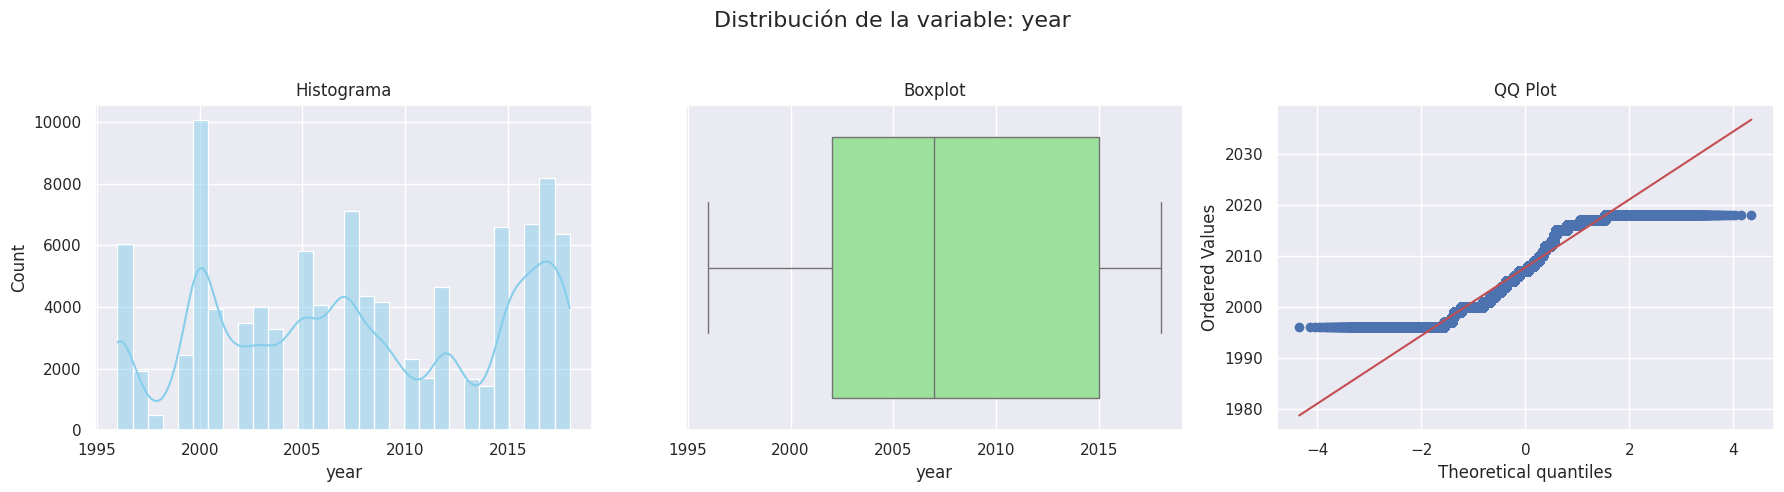

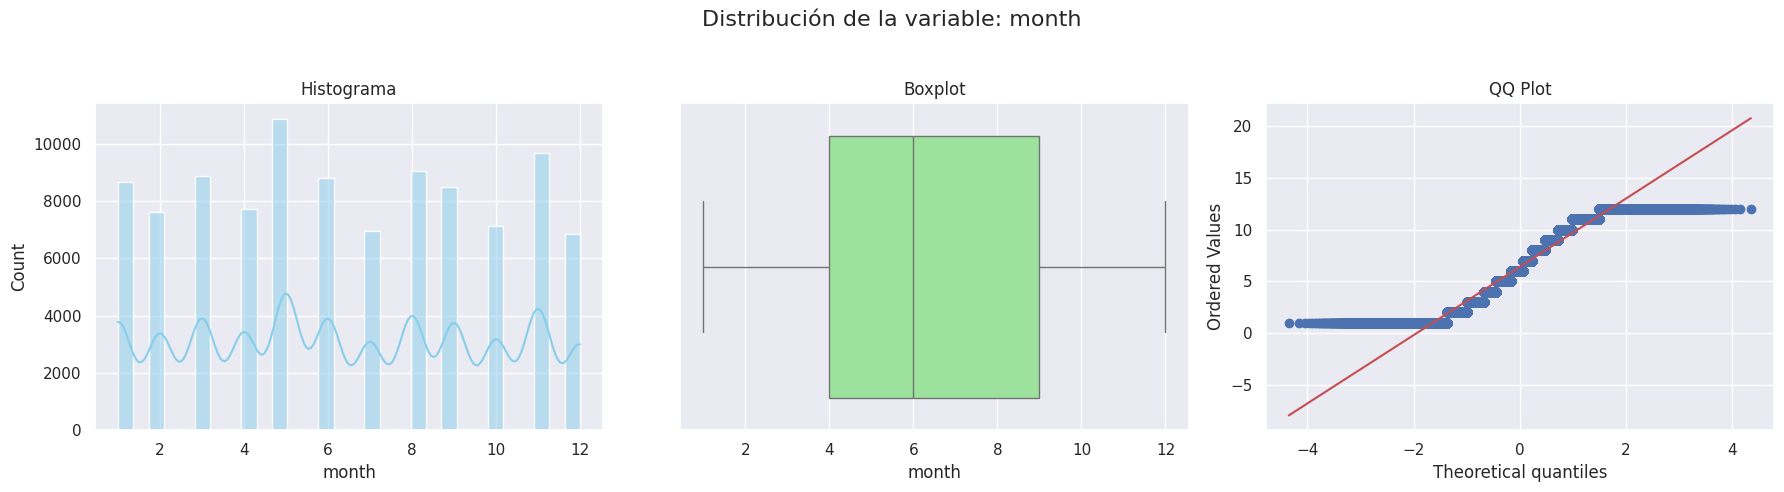

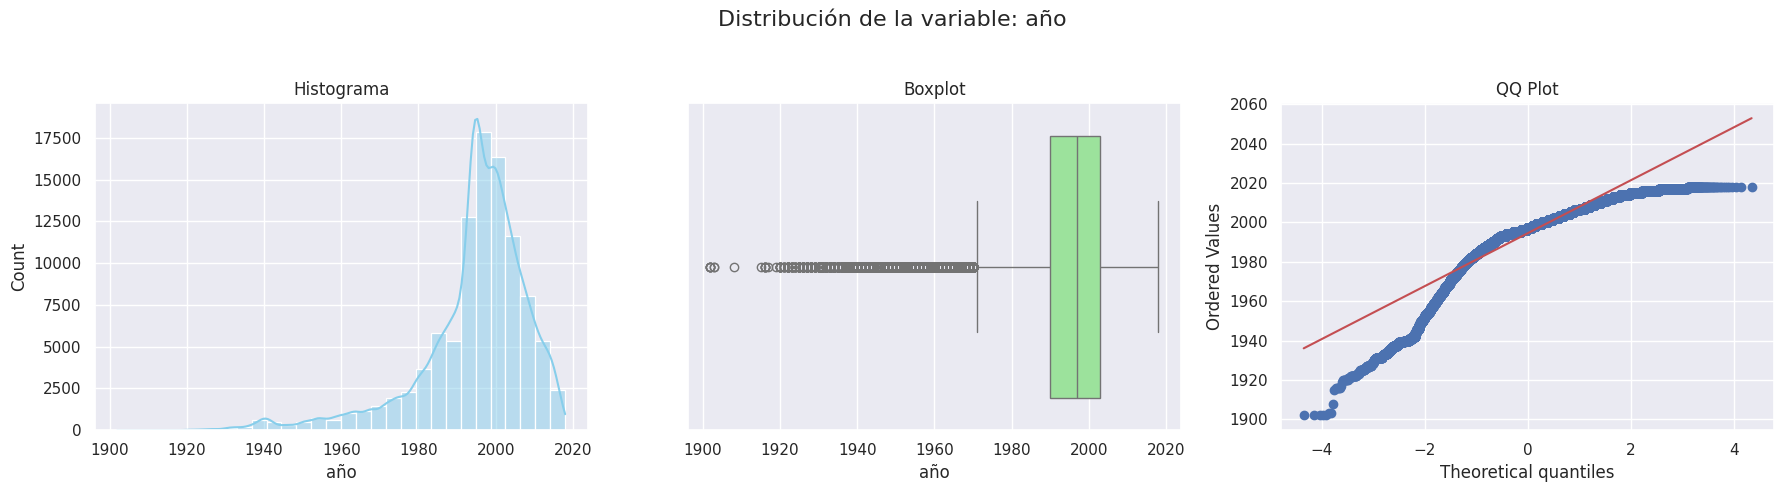

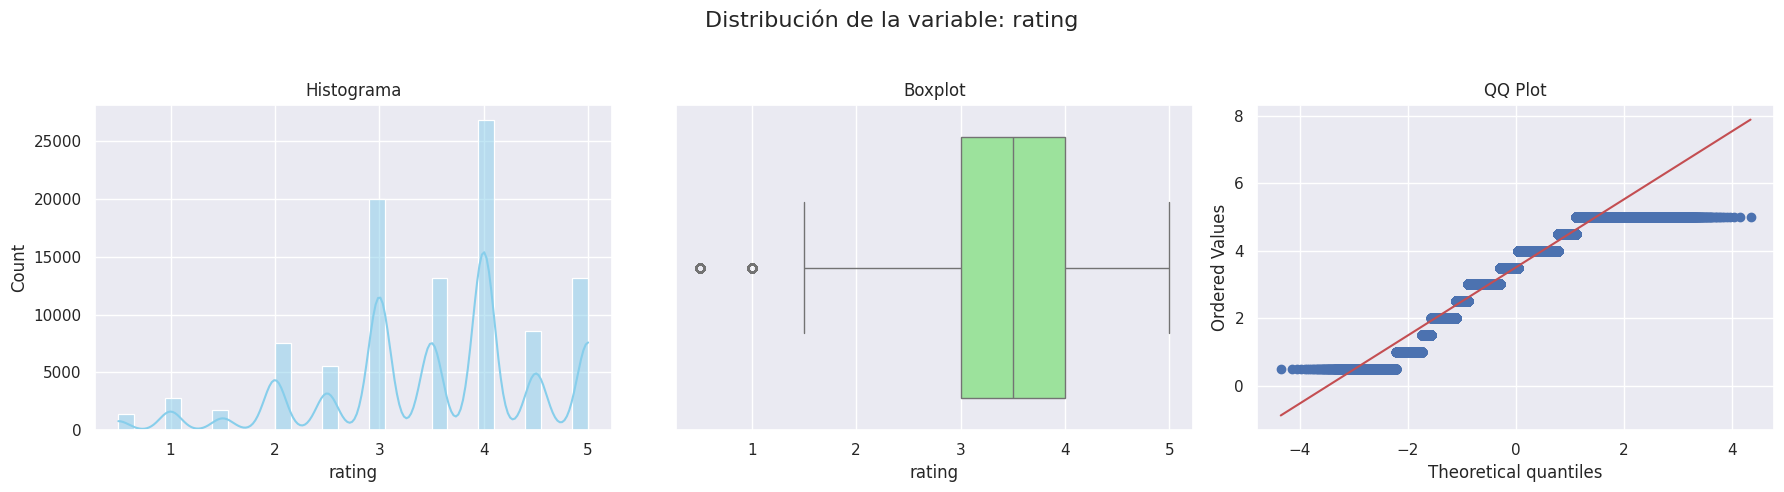

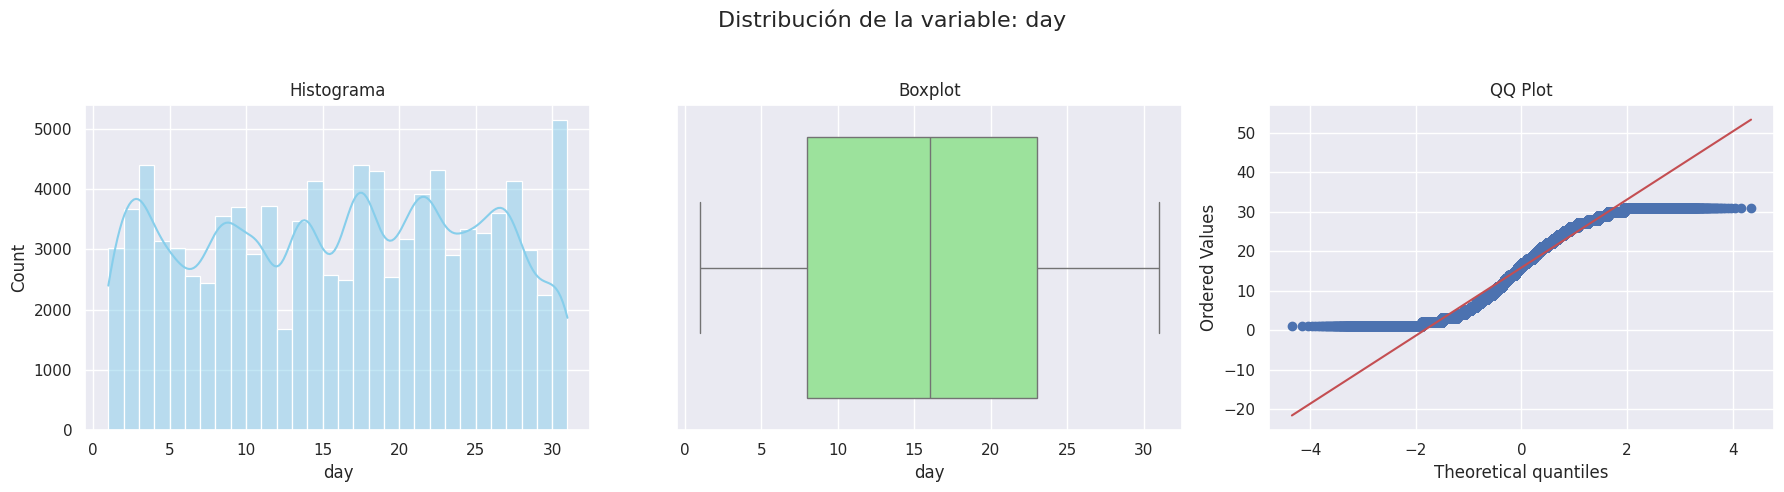

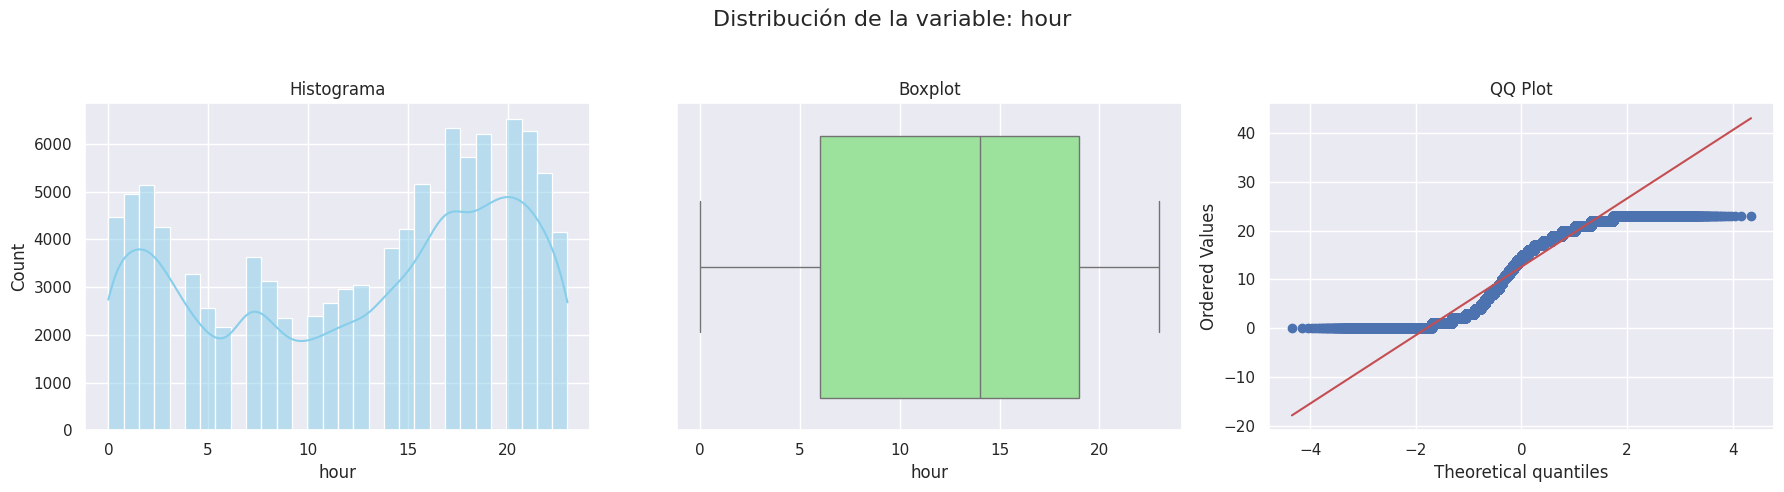

In [ ]:
variables = ['year', 'month', 'año', 'rating', 'day', 'hour']
graficos_distribucion(df, variables)


In [ ]:
import plotly.express as px

genre_counts = table_movies.drop(columns=['movieId', 'titulo', 'año']).sum().sort_values(ascending=False)
# Create the Plotly bar chart with vibrant colors
fig = px.bar(
    x=genre_counts.index,
    y=genre_counts.values,
    labels={'x': 'Genre', 'y': 'Count'},
    title='Distribution of Movies Genres',
    color=genre_counts.index,
    color_discrete_sequence=px.colors.qualitative.Dark24
)
fig.update_layout(
    xaxis_title="Genre",
    yaxis_title="Number of Movies",
    title_x=0.5,  # Center the title
    xaxis={'categoryorder':'total descending'} # Sort the bars by count
)
fig.show()


In [ ]:


import plotly.express as px

# Assuming you want to analyze the 'año' column (year)
year_counts = table_movies['año'].value_counts().sort_index()
fig = px.bar(
    x=year_counts.index,
    y=year_counts.values,
    labels={'x': 'Year', 'y': 'Number of Movies'},
    title='Number of Movies per Year',
    color=year_counts.index
)
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Movies",
    title_x=0.5,  # Center the title
    coloraxis_showscale=True # Show the color bar
)
fig.show()


In [ ]:
pd.read_sql_query("""
SELECT
    COUNT(*) - COUNT(titulo) AS titulo_nulls,
    COUNT(*) - COUNT(año) AS año_nulls,
    COUNT(*) - COUNT("no genres listed") AS no_genres_listed_nulls,
    COUNT(*) - COUNT(Action) AS Action_nulls,
    COUNT(*) - COUNT(Adventure) AS Adventure_nulls,
    COUNT(*) - COUNT(Animation) AS Animation_nulls,
    COUNT(*) - COUNT(Children) AS Children_nulls,
    COUNT(*) - COUNT(Comedy) AS Comedy_nulls,
    COUNT(*) - COUNT(Crime) AS Crime_nulls,
    COUNT(*) - COUNT(Documentary) AS Documentary_nulls,
    COUNT(*) - COUNT(Drama) AS Drama_nulls,
    COUNT(*) - COUNT(Fantasy) AS Fantasy_nulls,
    COUNT(*) - COUNT("Film-Noir") AS Film_Noir_nulls,
    COUNT(*) - COUNT(Horror) AS Horror_nulls,
    COUNT(*) - COUNT(IMAX) AS IMAX_nulls,
    COUNT(*) - COUNT(Musical) AS Musical_nulls,
    COUNT(*) - COUNT(Mystery) AS Mystery_nulls,
    COUNT(*) - COUNT(Romance) AS Romance_nulls,
    COUNT(*) - COUNT("Sci-Fi") AS Sci_Fi_nulls,
    COUNT(*) - COUNT(Thriller) AS Thriller_nulls,
    COUNT(*) - COUNT(War) AS War_nulls,
    COUNT(*) - COUNT(Western) AS Western_nulls
FROM movies
""", conexion)


,titulo_nulls,año_nulls,no_genres_listed_nulls,Action_nulls,Adventure_nulls,Animation_nulls,Children_nulls,Comedy_nulls,Crime_nulls,Documentary_nulls,...,Film_Noir_nulls,Horror_nulls,IMAX_nulls,Musical_nulls,Mystery_nulls,Romance_nulls,Sci_Fi_nulls,Thriller_nulls,War_nulls,Western_nulls
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
pd.read_sql_query("""
SELECT COUNT(*) - COUNT(DISTINCT movieId) AS duplicados
FROM movies
WHERE (movieId, titulo, año) IN (
    SELECT movieId, titulo, año
    FROM movies
    GROUP BY movieId, titulo, año
    HAVING COUNT(*) > 1
)
""", conexion)

,duplicados
0,0


##### TABLA RATINGS

In [ ]:
pd.read_sql_query("""
PRAGMA table_info(ratings);
""", conexion)

,cid,name,type,notnull,dflt_value,pk
0,0,userId,INTEGER,0,None,0
1,1,movieId,INTEGER,0,None,0
2,2,rating,REAL,0,None,0
3,3,day,INTEGER,0,None,0
4,4,month,INTEGER,0,None,0
5,5,hour,INTEGER,0,None,0
6,6,year,INTEGER,0,None,0


In [ ]:
pd.read_sql_query("""
SELECT
  SUM(userId IS NULL) AS userId_nulls,
  SUM(movieId IS NULL) AS movieId_nulls,
  SUM(rating IS NULL) AS rating_nulls,
  SUM(day IS NULL) AS day_nulls,
  SUM(month IS NULL) AS month_nulls,
  SUM(hour IS NULL) AS hour_nulls,
  SUM(year IS NULL) AS year_nulls
FROM ratings
""", conexion)

,userId_nulls,movieId_nulls,rating_nulls,day_nulls,month_nulls,hour_nulls,year_nulls
0,0,0,0,0,0,0,0


In [ ]:
pd.read_sql_query("""
SELECT
    'userId' AS columna,
    COUNT(userId) AS cantidad,
    AVG(userId) AS media,
    MIN(userId) AS minimo,
    MAX(userId) AS maximo
FROM ratings
UNION
SELECT
    'movieId' AS columna,
    COUNT(movieId),
    AVG(movieId),
    MIN(movieId),
    MAX(movieId)
FROM ratings
UNION
SELECT
    'rating' AS columna,
    COUNT(rating),
    AVG(rating),
    MIN(rating),
    MAX(rating)
FROM ratings
UNION
SELECT
    'day' AS columna,
    COUNT(day),
    AVG(day),
    MIN(day),
    MAX(day)
FROM ratings
UNION
SELECT
    'month' AS columna,
    COUNT(month),
    AVG(month),
    MIN(month),
    MAX(month)
FROM ratings
UNION
SELECT
    'hour' AS columna,
    COUNT(hour),
    AVG(hour),
    MIN(hour),
    MAX(hour)
FROM ratings
UNION
SELECT
    'year' AS columna,
    COUNT(year),
    AVG(year),
    MIN(year),
    MAX(year)
FROM ratings
""", conexion)


,columna,cantidad,media,minimo,maximo
0,day,100836,15.854367,1.0,31.0
1,hour,100836,12.609167,0.0,23.0
2,month,100836,6.413811,1.0,12.0
3,movieId,100836,19435.295718,1.0,193609.0
4,rating,100836,3.501557,0.5,5.0
5,userId,100836,326.127564,1.0,610.0
6,year,100836,2007.722936,1996.0,2018.0


In [ ]:
pd.read_sql_query("""
SELECT COUNT(*) - COUNT(*) AS duplicados
FROM (SELECT userId, movieId, rating, day, month, hour, year FROM ratings GROUP BY userId, movieId, rating, day, month, hour, year HAVING COUNT(*) > 1) AS duplicados
""", conexion)

,duplicados
0,0


#### PREGUNTAS PARA EXPLORACIÓN GENERAL

¿Cuántas películas hay registradas en total?

¿Cuántos géneros diferentes existen?

¿Cuál es el género más común entre las películas?

¿Cuántas calificaciones (ratings) hay en total?

¿Cuántos usuarios distintos han dado calificaciones?

¿Qué película tiene más calificaciones?

¿Qué usuario ha dado más calificaciones?

¿Cuál es la distribución de las calificaciones? (¿hay más 5.0, 4.0, etc.?)

¿Existen películas sin ninguna calificación?

¿Cuál es el promedio de calificación por película?

¿Cuál es el promedio de calificación por usuario?

¿Cuál es el rango de años de las películas? (¿de qué año a qué año?)

In [ ]:
query = "SELECT COUNT(*) AS total_peliculas FROM movies;"
pd.read_sql_query(query, conexion)


,total_peliculas
0,9718


In [ ]:
total_generos = genre_counts.shape[0]
print("Total de géneros:", total_generos)

Total de géneros: 20


#### PREGUNTAS PARA DETENCCIÓN DE PROBLEMAS O CALIDAD DE DATOS

¿Hay películas con el mismo nombre pero diferente movieId?

¿Hay calificaciones fuera del rango esperado (por ejemplo, menores a 0 o mayores a 5)?

¿Existen valores nulos o vacíos en alguna columna?

¿Hay géneros desconocidos o no estandarizados?

¿Hay películas sin año de estreno?

In [ ]:
#¿Hay películas con el mismo nombre pero diferente movieId?
#Suma la cantidad de peliculas duplicadas
total_movieId_duplicados = pd.read_sql_query("""
SELECT SUM(cantidad_ids) AS total_duplicados
FROM (
    SELECT COUNT(DISTINCT movieId) AS cantidad_ids
    FROM movies
    GROUP BY titulo
    HAVING COUNT(DISTINCT movieId) > 1
) AS subquery
""", conexion)
total_movieId_duplicados

,total_duplicados
0,536


In [ ]:
#Muestra el movieId que tiene diferente pero el nombre de la pelicula es la misma
peliculas_con_ids = pd.read_sql_query("""
SELECT ROWID, titulo, movieId
FROM movies
WHERE titulo IN (
    SELECT titulo
    FROM movies
    GROUP BY titulo
    HAVING COUNT(DISTINCT movieId) > 1
)
ORDER BY titulo
""", conexion)

peliculas_con_ids


,rowid,titulo,movieId
0,906,12 Angry Men,1203
1,7329,12 Angry Men,77846
2,9034,12 Chairs,141816
3,9039,12 Chairs,141844
4,778,"20,000 Leagues Under the Sea",1019
5,6860,"20,000 Leagues Under the Sea",62383
6,3792,3:10 to Yuma,5300
7,6556,3:10 to Yuma,54997
8,3117,Alfie,4191
9,5365,Alfie,8948


In [ ]:
#¿Hay calificaciones fuera del rango esperado (por ejemplo, menores a 0 o mayores a 5)?
calificaciones_fuera_rango = pd.read_sql_query("""
SELECT *
FROM ratings
WHERE rating < 0 OR rating > 5
""", conexion)

calificaciones_fuera_rango

,userId,movieId,rating,day,month,hour,year


In [ ]:
#¿Hay géneros desconocidos o sin genero?
pd.read_sql_query("""
SELECT COUNT(*) AS peliculas_sin_generos
FROM movies
WHERE "(no genres listed)" = 1
""", conexion)

,peliculas_sin_generos
0,25


In [ ]:
#¿Qué peliculas no tienen genero?
pd.read_sql_query("""
SELECT movieId, titulo
FROM movies
WHERE "(no genres listed)" = 1
""", conexion)

,movieId,titulo
0,114335,La cravate
1,122888,Ben-hur
2,122896,Pirates of the Caribbean: Dead Men Tell No Tales
3,129250,Superfast!
4,132084,Let It Be Me
5,134861,Trevor Noah: African American
6,141131,Guardians
7,141866,Green Room
8,142456,The Brand New Testament
9,149330,A Cosmic Christmas


In [ ]:
#¿Hay películas sin año de estreno?
pd.read_sql_query("""
SELECT COUNT(*) AS peliculas_sin_año
FROM movies
WHERE año IS NULL OR año = ''
""", conexion)

,peliculas_sin_año
0,0


#### PREGUNTAS PARA VISUALIZACIÓN DE DISTRIBUCIONES

Cómo es la distribución de las calificaciones?

¿Cómo es la distribución del número de calificaciones por película?

¿Cómo es la distribución del número de calificaciones por usuario?

¿Cómo varía la calificación promedio a lo largo de los años?

#### PREGUNTA ANÁLISIS AVANZADO



(Cruzar tablas y buscar patrones)

¿Cuál es el género que tiene mejores calificaciones promedio?

¿Las películas más recientes tienen mejores calificaciones que las antiguas?

¿Qué usuarios tienden a calificar más bajo o más alto?

¿Hay algún patrón entre género y año de estreno?

¿Cuál es la película mejor calificada?

¿Cuál es la película peor calificada?

¿Existe algún año donde se estrenaron muchas películas de un género específico?

¿Cómo cambia la popularidad de géneros a lo largo del tiempo?

In [ ]:
query = """SELECT m.año,
    SUM(Action) AS Action,
    SUM(Comedy) AS Comedy,
    SUM(Drama) AS Drama,
    SUM(Horror) AS Horror,
    SUM(Romance) AS Romance,
    SUM(Thriller) AS Thriller,
    SUM(Adventure) AS Adventure,
    SUM(Animation) AS Animation,
    SUM(Children) AS Children,
    SUM(Documentary) AS Documentary,
    SUM(Fantasy) AS Fantasy,
    SUM(IMAX) AS IMAX,
    SUM(Musical) AS Musical,
    SUM(Mystery) AS Mystery,
    SUM(War) AS War,
    SUM(Western) AS Western,
    SUM("Film-Noir") AS "Film-Noir",
    SUM("Sci-Fi") AS "Sci-Fi"
FROM movies m
GROUP BY m.año
ORDER BY m.año DESC
LIMIT 5
"""
pd.read_sql_query(query, conexion)

,año,Action,Comedy,Drama,Horror,Romance,Thriller,Adventure,Animation,Children,Documentary,Fantasy,IMAX,Musical,Mystery,War,Western,Film-Noir,Sci-Fi
0,2018,17,17,9,4,1,14,12,3,3,2,7,0,0,5,0,0,0,14
1,2017,38,56,45,13,6,22,24,18,9,10,14,0,0,6,3,2,0,18
2,2016,48,75,71,16,18,42,36,22,13,13,22,0,0,8,3,1,0,29
3,2015,63,104,101,36,21,57,45,19,14,19,21,1,1,16,2,4,0,41
4,2014,62,116,117,28,35,60,35,15,15,17,15,14,5,16,8,3,0,32


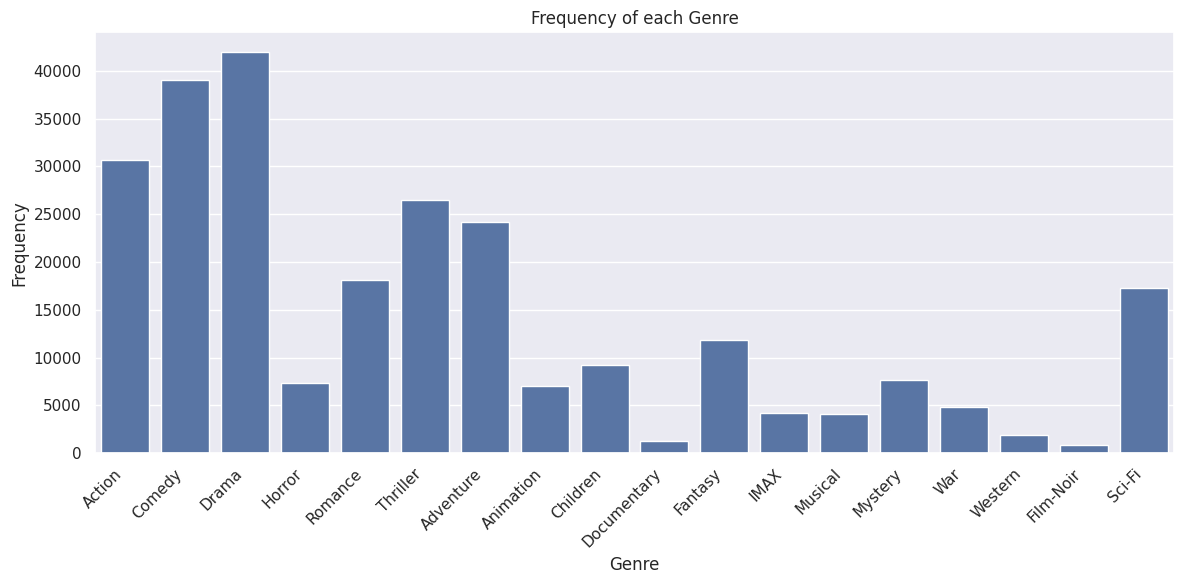

In [ ]:
# prompt: EN df hay unas columnas de generos que son binarias quiero un grafico de contingecia para ver la frecuencia de cada genero

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame with the binary genre columns
genre_columns = ['Action', 'Comedy', 'Drama', 'Horror', 'Romance', 'Thriller', 'Adventure', 'Animation', 'Children', 'Documentary', 'Fantasy', 'IMAX', 'Musical', 'Mystery', 'War', 'Western', 'Film-Noir', 'Sci-Fi']

# Calculate the contingency table
contingency_table = df[genre_columns].sum()

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=contingency_table.index, y=contingency_table.values)
plt.title('Frequency of each Genre')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()


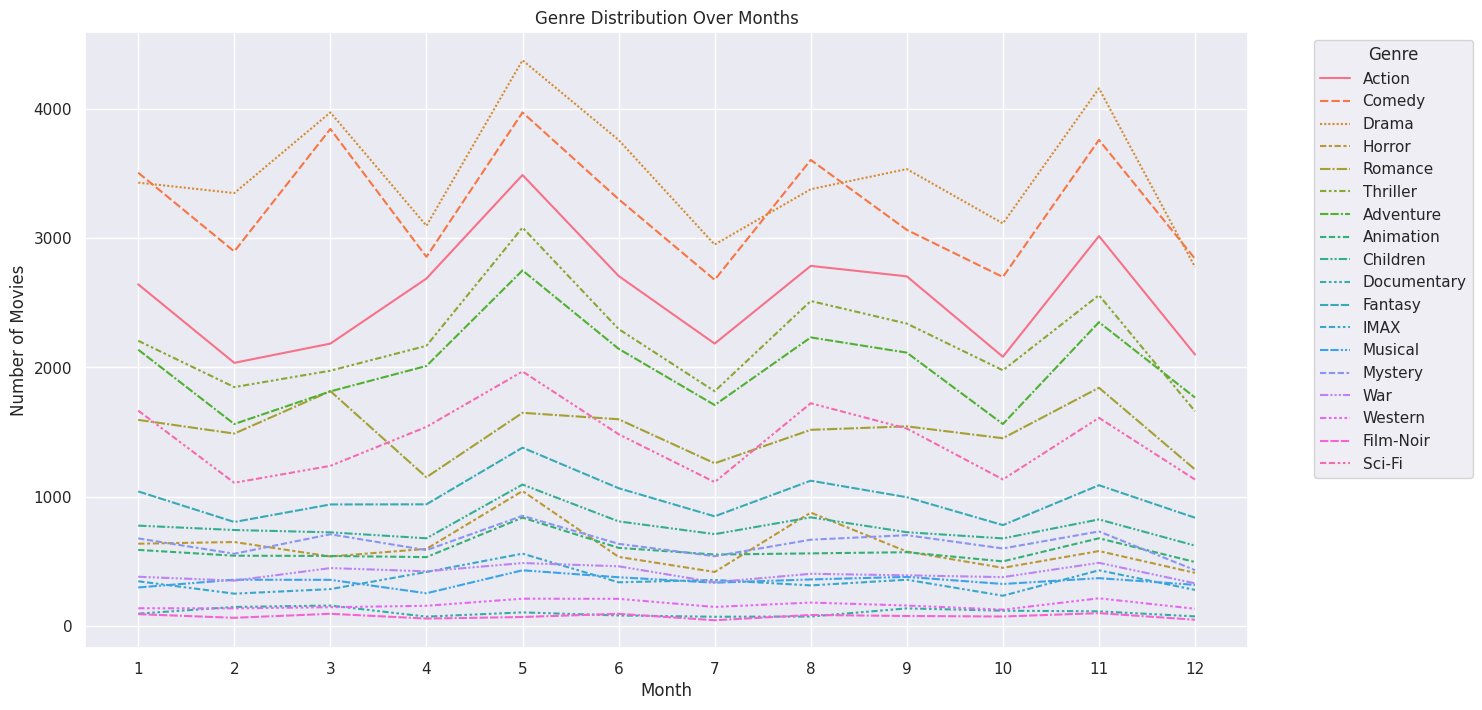

In [ ]:
# prompt: quiero ver los  generos por meses

# Assuming 'df' is your DataFrame from the previous code
import matplotlib.pyplot as plt
import seaborn as sns

# Group by month and genre, then count the occurrences
genre_by_month = df.groupby('month')[genre_columns].sum()

# Create the plot
plt.figure(figsize=(15, 8))
sns.lineplot(data=genre_by_month)
plt.title('Genre Distribution Over Months')
plt.xlabel('Month')
plt.ylabel('Number of Movies')
plt.xticks(range(1, 13))  # Set x-axis ticks to represent months (1 to 12)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend outside plot
plt.show()


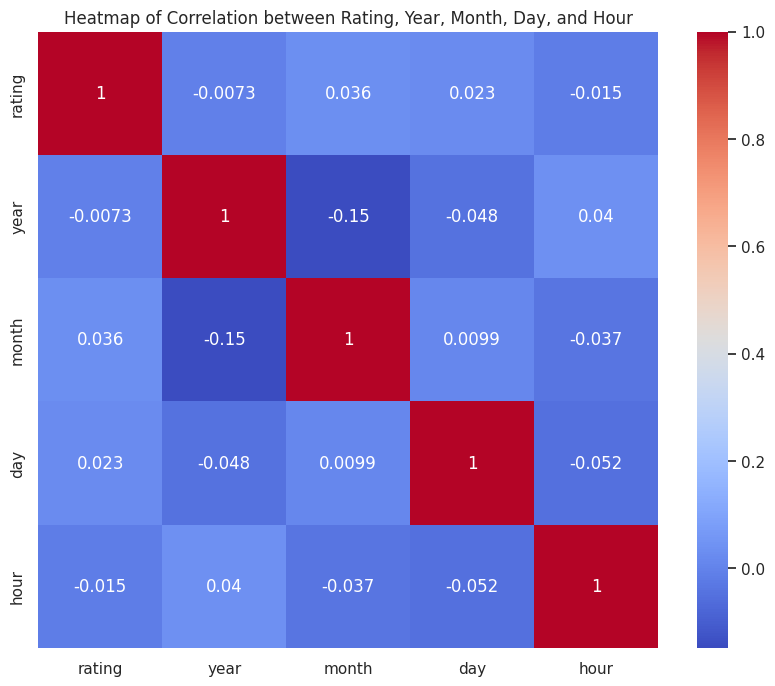

In [ ]:
# prompt: regalame un mapa de calor entre rating, year, month,day, año, hour

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame containing 'rating', 'year', 'month', 'day', 'hour' columns
# Replace 'df' with your actual DataFrame name

plt.figure(figsize=(10, 8))
sns.heatmap(df[['rating', 'year', 'month', 'day', 'hour']].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap of Correlation between Rating, Year, Month, Day, and Hour')
plt.show()


In [24]:
query_populares = """
SELECT
    m.movieId,
    m.titulo,
    COUNT(r.rating) AS cantidad_votos
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.movieId
ORDER BY cantidad_votos DESC
LIMIT 10;
"""

populares_df = pd.read_sql_query(query_populares, conexion)
display(populares_df)


,movieId,titulo,cantidad_votos
0,356,Forrest Gump,329
1,318,"Shawshank Redemption, The",317
2,296,Pulp Fiction,307
3,593,"Silence of the Lambs, The",279
4,2571,"Matrix, The",278
5,260,Star Wars: Episode IV - A New Hope,251
6,480,Jurassic Park,238
7,110,Braveheart,237
8,589,Terminator 2: Judgment Day,224
9,527,Schindler's List,220


In [25]:
query_mejor_calificadas = """
SELECT
    m.movieId,
    m.titulo,
    COUNT(r.rating) AS cantidad_votos,
    AVG(r.rating) AS promedio_rating
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.movieId
HAVING cantidad_votos >= 50
ORDER BY promedio_rating DESC
LIMIT 10;
"""

mejores_df = pd.read_sql_query(query_mejor_calificadas, conexion)
display(mejores_df)


,movieId,titulo,cantidad_votos,promedio_rating
0,318,"Shawshank Redemption, The",317,4.429022
1,858,"Godfather, The",192,4.289062
2,2959,Fight Club,218,4.272936
3,1276,Cool Hand Luke,57,4.271930
4,750,Dr. Strangelove or: How I Learned to Stop Worr...,97,4.268041
5,904,Rear Window,84,4.261905
6,1221,"Godfather: Part II, The",129,4.259690
7,48516,"Departed, The",107,4.252336
8,1213,Goodfellas,126,4.250000
9,912,Casablanca,100,4.240000


In [26]:
# Paso 1: calcular el promedio general C
promedio_general = pd.read_sql_query("SELECT AVG(rating) as promedio FROM ratings", conexion).iloc[0]['promedio']
m = 50  # mínimo de votos

# Paso 2: extraer info de películas con suficientes votos
query_rank = f"""
SELECT
    m.movieId,
    m.titulo,
    COUNT(r.rating) AS v,
    AVG(r.rating) AS R
FROM ratings r
JOIN movies m ON r.movieId = m.movieId
GROUP BY m.movieId
HAVING v >= {m}
"""

peliculas_df = pd.read_sql_query(query_rank, conexion)

# Paso 3: aplicar la fórmula
C = promedio_general
peliculas_df['score'] = (peliculas_df['v'] / (peliculas_df['v'] + m)) * peliculas_df['R'] + (m / (peliculas_df['v'] + m)) * C

# Paso 4: ordenar por score
recomendaciones_df = peliculas_df.sort_values(by='score', ascending=False).head(10)
display(recomendaciones_df)


,movieId,titulo,v,R,score
53,318,"Shawshank Redemption, The",317,4.429022,4.302665
277,2959,Fight Club,218,4.272936,4.129023
118,858,"Godfather, The",192,4.289062,4.126356
44,260,Star Wars: Episode IV - A New Hope,251,4.231076,4.109894
49,296,Pulp Fiction,307,4.197068,4.099659
18,50,"Usual Suspects, The",204,4.237745,4.092827
87,527,Schindler's List,220,4.225000,4.091030
252,2571,"Matrix, The",278,4.192446,4.087128
142,1196,Star Wars: Episode V - The Empire Strikes Back,211,4.215640,4.078843
62,356,Forrest Gump,329,4.164134,4.076723


<ipython-input-27-390b712e31cd>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-27-390b712e31cd>:9: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.



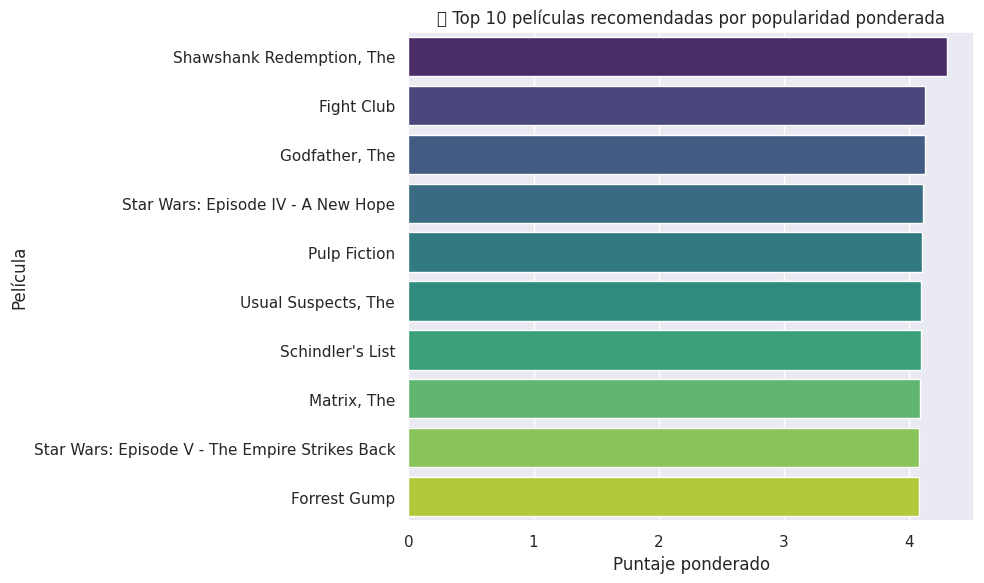

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(data=recomendaciones_df, x='score', y='titulo', palette='viridis')
plt.title("🎯 Top 10 películas recomendadas por popularidad ponderada")
plt.xlabel("Puntaje ponderado")
plt.ylabel("Película")
plt.tight_layout()
plt.show()


In [ ]:
## SISTEMAS DE RECOMENDACION BASADAS EN CONTENIDO

In [28]:
query_generos = """
SELECT movieId, titulo,
       Action, Comedy, Drama, Horror, Romance, Thriller,
       Adventure, Animation, Children, Documentary,
       Fantasy, IMAX, Musical, Mystery, War, Western, "Film-Noir"
FROM movies;
"""

peliculas_df = pd.read_sql_query(query_generos, conexion)
peliculas_df.set_index('movieId', inplace=True)


In [29]:
from sklearn.metrics.pairwise import cosine_similarity

# Extraer solo columnas de géneros
generos = peliculas_df.drop(columns=['titulo'])

# Calcular matriz de similitud
similitud = cosine_similarity(generos)

# Convertir a DataFrame
import numpy as np
similitud_df = pd.DataFrame(similitud, index=peliculas_df.index, columns=peliculas_df.index)


In [30]:
def recomendar_peliculas(movie_title, peliculas_df, similitud_df, top_n=5):
    # Buscar el ID de la película
    pelicula_id = peliculas_df[peliculas_df['titulo'].str.lower() == movie_title.lower()].index

    if pelicula_id.empty:
        print("Película no encontrada.")
        return

    pelicula_id = pelicula_id[0]

    # Obtener las similitudes
    similares = similitud_df[pelicula_id].sort_values(ascending=False)

    # Excluir la misma película
    similares = similares.drop(pelicula_id)

    # Obtener títulos de las películas similares
    recomendadas = peliculas_df.loc[similares.head(top_n).index, 'titulo']

    print(f"\n🎬 Películas similares a: {peliculas_df.loc[pelicula_id, 'titulo']}\n")
    for i, titulo in enumerate(recomendadas, 1):
        print(f"{i}. {titulo}")


In [41]:
recomendar_peliculas("Toy Story", peliculas_df, similitud_df)



🎬 Películas similares a: Toy Story

1. Adventures of Rocky and Bullwinkle, The
2. Tale of Despereaux, The
3. Asterix and the Vikings (Astérix et les Vikings)
4. The Good Dinosaur
5. Home


In [ ]:
## recoemndacion colaborativa

In [32]:
import pandas as pd

# Leer los datos de ratings (si no están cargados ya)
ratings_query = """
SELECT * FROM ratings;
"""
ratings_df = pd.read_sql_query(ratings_query, conexion)

# Crear la matriz de usuario vs película
ratings_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')

# Ver la matriz de calificaciones
ratings_matrix.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Rellenar valores nulos con la media de las calificaciones de cada película
ratings_matrix_filled = ratings_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

# Ver la matriz con valores completados
ratings_matrix_filled.head()


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.000000,4.366379,4.000000,4.366379,4.366379,4.000000,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,4.000000,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [34]:
from sklearn.metrics.pairwise import cosine_similarity

# Calcular la similitud entre usuarios
user_similarity = cosine_similarity(ratings_matrix_filled)

# Convertir la matriz de similitudes a un DataFrame
user_similarity_df = pd.DataFrame(user_similarity, index=ratings_matrix_filled.index, columns=ratings_matrix_filled.index)

# Ver las primeras similitudes
user_similarity_df.head()


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.999540,0.998160,0.998164,0.999447,0.998588,0.998274,0.999449,0.999261,0.998669,...,0.999552,0.999010,0.994342,0.999343,0.998831,0.997378,0.999032,0.994775,0.999559,0.996020
2,0.999540,1.000000,0.998499,0.998417,0.999780,0.998974,0.998616,0.999754,0.999586,0.999020,...,0.999880,0.999354,0.994722,0.999706,0.999202,0.997699,0.999308,0.994893,0.999899,0.996356
3,0.998160,0.998499,1.000000,0.997016,0.998364,0.997615,0.997243,0.998351,0.998206,0.997639,...,0.998502,0.997956,0.993448,0.998325,0.997819,0.996182,0.997921,0.993456,0.998524,0.995045
4,0.998164,0.998417,0.997016,1.000000,0.998294,0.997567,0.997336,0.998315,0.998126,0.997690,...,0.998412,0.998032,0.993435,0.998238,0.997836,0.996321,0.997893,0.993248,0.998444,0.994881
5,0.999447,0.999780,0.998364,0.998294,1.000000,0.998887,0.998528,0.999656,0.999482,0.998889,...,0.999785,0.999269,0.994671,0.999606,0.999073,0.997622,0.999232,0.994793,0.999815,0.996228


In [35]:
def recomendar_peliculas_collaborative(user_id, ratings_matrix, user_similarity_df, top_n=5):
    # Obtener las películas que el usuario ya ha calificado
    rated_movies = ratings_matrix.loc[user_id].dropna().index

    # Obtener usuarios más similares
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).drop(user_id)

    # Tomar los usuarios más similares
    most_similar_users = similar_users.head(top_n).index

    # Recomendaciones basadas en los usuarios más similares
    recommended_movies = []
    for user in most_similar_users:
        movies_rated_by_similar_user = ratings_matrix.loc[user].dropna().index
        for movie in movies_rated_by_similar_user:
            if movie not in rated_movies:
                recommended_movies.append(movie)

    # Obtener los títulos de las películas recomendadas
    recommended_movie_titles = peliculas_df.loc[recommended_movies, 'titulo'].dropna()

    print(f"\n🎥 Películas recomendadas para el usuario {user_id}:\n")
    for i, movie in enumerate(recommended_movie_titles.head(top_n), 1):
        print(f"{i}. {movie}")


In [39]:
recomendar_peliculas_collaborative(6, ratings_matrix, user_similarity_df)



🎥 Películas recomendadas para el usuario 6:

1. Toy Story
2. Sudden Death
3. Four Rooms
4. Mighty Aphrodite
5. Quiz Show


In [ ]:
## sistema de recomendacion por año de estreno

In [59]:
def recomendar_por_año(df, año, top_n=10):
    """
    Recomienda películas del año indicado, ordenadas por calificación promedio.

    Parámetros:
    - df: DataFrame con las columnas 'movieId', 'titulo', 'year', 'rating'
    - año: Año de estreno (int)
    - top_n: Número de películas recomendadas

    Retorna:
    - DataFrame con las películas recomendadas
    """
    # Filtrar por año
    df_filtrado = df[df['year'] == año]

    if df_filtrado.empty:
        print(f"No se encontraron películas del año {año}.")
        return pd.DataFrame()

    # Calcular promedio de rating por película
    recomendaciones = (
        df_filtrado
        .groupby(['movieId', 'titulo'])
        .agg(promedio_rating=('rating', 'mean'), total_votos=('rating', 'count'))
        .reset_index()
        .sort_values(by='promedio_rating', ascending=False)
    )

    return recomendaciones.head(top_n)


In [61]:
# Recomendaciones para el año 2010
recomendar_por_año(df, 2014)


,movieId,titulo,promedio_rating,total_votos
980,110127,Noah,5.0,1
793,94810,Eva,5.0,1
781,92535,Louis C.K.: Live at the Beacon Theater,5.0,1
970,109487,Interstellar,5.0,2
909,104069,Louis C.K.: Oh My God,5.0,1
581,50872,Ratatouille,5.0,1
533,34405,Serenity,5.0,1
496,8914,Primer,5.0,1
435,6442,Belle époque,5.0,1
475,7573,Never Say Never Again,5.0,1


In [ ]:
###recomendacion ppr genero

In [62]:
def recomendar_por_genero(df, genero, top_n=10, min_votos=10):
    """
    Recomienda películas dentro de un género específico.

    Parámetros:
    - df: DataFrame unido de ratings y movies
    - genero: string del nombre del género (por ejemplo, 'Comedy')
    - top_n: número de películas recomendadas
    - min_votos: mínimo de calificaciones para considerar la película

    Retorna:
    - DataFrame con películas recomendadas
    """
    # Verificar que el género existe en las columnas
    if genero not in df.columns:
        print(f"Género '{genero}' no encontrado.")
        return pd.DataFrame()

    # Filtrar las películas que pertenecen a ese género
    df_genero = df[df[genero] == 1]

    # Calcular promedio de rating y número de votos
    recomendaciones = (
        df_genero
        .groupby(['movieId', 'titulo'])
        .agg(promedio_rating=('rating', 'mean'), total_votos=('rating', 'count'))
        .reset_index()
    )

    # Filtrar por mínimo de votos
    recomendaciones = recomendaciones[recomendaciones['total_votos'] >= min_votos]

    # Ordenar por promedio de rating
    recomendaciones = recomendaciones.sort_values(by='promedio_rating', ascending=False)

    return recomendaciones.head(top_n)


In [63]:
recomendar_por_genero(df, 'Action', top_n=10)


,movieId,titulo,promedio_rating,total_votos
233,1927,All Quiet on the Western Front,4.350000,10
141,1209,Once Upon a Time in the West (C'era una volta ...,4.305556,18
1110,55721,Elite Squad (Tropa de Elite),4.300000,10
1772,168252,Logan,4.280000,25
362,2959,Fight Club,4.272936,218
412,3508,"Outlaw Josey Wales, The",4.250000,18
1130,58559,"Dark Knight, The",4.238255,149
136,1197,"Princess Bride, The",4.232394,142
36,260,Star Wars: Episode IV - A New Hope,4.231076,251
373,3030,Yojimbo,4.230769,13
